# Notebook Lecture 1: Introduction, Digital Control Systems
© 2025 ETH Zurich, Niclas Scheuer; Institute for Dynamic Systems and Control; Prof. Emilio Frazzoli

This interactive notebook covers the basics of discrete-time control and aliasing.

Authors:
- Niclas Scheuer; nscheuer@ethz.ch

## Import the packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from scipy.optimize import curve_fit
from IPython.display import display

# Example 1: Zero-Order Hold

The zero-order hold is perhaps the simplest method to turn a _discrete-time_ (DT) signal into a _continuous-time_ (CT) signal. It does this by taking the value of the input at time $$t_0 = kT$$ and holding this output for the whole sampling period $$t \in [kT, (k+1)T)$$



In [ ]:
def zero_order_hold_plot(fs):
    T = 2  # Total time in seconds
    t_cont = np.linspace(0, T, 1000)  # Continuous time axis
    signal_cont = np.sin(2 * np.pi * 1 * t_cont)  # Continuous sine wave
    
    t_samples = np.arange(0, T, 1/fs)  # Discrete sample times
    signal_samples = np.sin(2 * np.pi * 1 * t_samples)  # Sampled signal
    
    # Create ZOH signal by repeating each sample value until the next sample
    t_zoh = np.repeat(t_samples, 2)
    signal_zoh = np.repeat(signal_samples, 2)
    
    # Adjust last element to match the original timeline
    t_zoh = np.append(t_zoh, T)
    signal_zoh = np.append(signal_zoh, signal_zoh[-1])
    
    plt.figure(figsize=(8, 4))
    plt.plot(t_cont, signal_cont, 'b', label='Original Signal')  # Continuous signal
    plt.step(t_zoh, signal_zoh, 'r', where='post', label='Zero-Order Hold')  # ZOH signal
    plt.scatter(t_samples, signal_samples, color='black', zorder=3, label='Samples')  # Sample points
    
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(f'Zero-Order Hold (Sampling Frequency = {fs} Hz)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Create slider for sampling frequency
fs_slider = widgets.IntSlider(min=1, max=30, step=1, value=5, description='Fs (Hz)')
interactive_plot = widgets.interactive_output(zero_order_hold_plot, {'fs': fs_slider})
display(fs_slider, interactive_plot)


IntSlider(value=5, description='Fs (Hz)', max=30, min=1)

Output()

# Example 2: Nyquist-Shannon Sampling Theorem

If we don't sample a signal often enough, we lose important details, making it hard to reconstruct the original signal.

## Sinuisoidal Signals and Sampling
Since any signal can be broken down into sine waves using the Fourier transform, we use a basic sinusoidal signal to explain the Nyquist-Shannon Sampling Theorem.

## Nyquist-Shannon Sampling Theorem
A sampled signal can be perfectly reconstructed only if the sampling rate is at least twice the highest frequency present in the signal.

$$
f_s \geq 2f_{max}
$$

where:
- $f_s$ is the **sampling frequency**
- $f_{max}$ is the **highest frequency component** in the signal





In [3]:
# Function to generate a sinusoidal signal
def sinusoid(t, f):
    return np.sin(2 * np.pi * f * t)

# Function to fit a sinusoid to sampled points using the lowest frequency possible
def fit_sinusoid(t_samples, y_samples, f_s):
    def model(t, A, f_fit, phase):
        return A * np.sin(2 * np.pi * f_fit * t + phase)
    
    # Nyquist folding to find the aliased frequency
    f_alias = np.abs((f_samples := np.fft.fftfreq(len(t_samples), d=(t_samples[1] - t_samples[0])))[np.argmax(np.abs(np.fft.fft(y_samples)))])
    f_guess = f_alias if f_alias < f_s / 2 else f_s - f_alias
    
    params, _ = curve_fit(model, t_samples, y_samples, p0=[1, f_guess, 0])
    return lambda t: model(t, *params)

# Interactive function to update the plot
def nyquist_plot(f_max, f_s):
    T = 1  # Total duration (1 second)
    t_cont = np.linspace(0, T, 1000)  # High-resolution time for continuous signal
    y_cont = sinusoid(t_cont, f_max)  # Continuous signal

    # Sampling points
    t_samples = np.arange(0, T, 1/f_s)  # Sampled times
    y_samples = sinusoid(t_samples, f_max)  # Sampled values

    # Fit a sinusoid to sampled points
    fitted_sinusoid = fit_sinusoid(t_samples, y_samples, f_s)

    # Generate reconstructed signal
    y_reconstructed = fitted_sinusoid(t_cont)

    # Plot the results
    plt.figure(figsize=(8, 4))
    plt.plot(t_cont, y_cont, 'b', label='Original Signal')  # Continuous signal
    plt.scatter(t_samples, y_samples, color='red', zorder=3, label='Sampled Points')  # Sampled points
    plt.plot(t_cont, y_reconstructed, 'g--', label='Reconstructed Signal')  # Fitted sinusoid
    
    # Nyquist Criterion Check
    nyquist_condition = f_s >= 2 * f_max
    condition_text = "✓ Nyquist Theorem Fulfilled" if nyquist_condition else "✗ Undersampling (Aliasing Can Occur!)"
    plt.title(f'Nyquist-Shannon Sampling Theorem\n{condition_text}', fontsize=12, color='green' if nyquist_condition else 'red')

    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)
    plt.show()

# Create interactive sliders
f_max_slider = widgets.FloatSlider(min=1, max=10, step=0.5, value=3, description='f_max (Hz)')
f_s_slider = widgets.FloatSlider(min=2, max=20, step=0.5, value=6, description='f_s (Hz)')

# Display interactive plot
interactive_plot = widgets.interactive_output(nyquist_plot, {'f_max': f_max_slider, 'f_s': f_s_slider})
display(f_max_slider, f_s_slider, interactive_plot)


FloatSlider(value=3.0, description='f_max (Hz)', max=10.0, min=1.0, step=0.5)

FloatSlider(value=6.0, description='f_s (Hz)', max=20.0, min=2.0, step=0.5)

Output()

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.fftpack import fft, fftfreq
import ipywidgets as widgets
from IPython.display import display

# Global storage for the original signal
global_t_cont = np.linspace(0, 1, 1000)  # High-resolution time
global_freq_options = np.array([1, 2, 5, 10, 20])  # Available frequency components
global_num_components = 2  # Default number of harmonics
global_f_s = 20  # Default sampling frequency

def generate_signal(num_components):
    global global_freqs, global_amps, global_phases, global_y_cont
    global_freqs = global_freq_options[:num_components]
    global_amps = np.ones(len(global_freqs))
    global_phases = np.random.uniform(0, 2*np.pi, len(global_freqs))
    global_y_cont = sum(A * np.sin(2 * np.pi * f * global_t_cont + p) for A, f, p in zip(global_amps, global_freqs, global_phases))

generate_signal(global_num_components)

# Function to fit multiple sinusoids to sampled points
def fit_sinusoids(t_samples, y_samples, freqs):
    def model(t, *params):
        A = params[:len(freqs)]
        P = params[len(freqs):]
        return sum(A[i] * np.sin(2 * np.pi * freqs[i] * t + P[i]) for i in range(len(freqs)))
    
    p0 = [1] * len(freqs) + [0] * len(freqs)  # Initial guess: Amplitudes = 1, Phases = 0
    params, _ = curve_fit(model, t_samples, y_samples, p0=p0)
    return lambda t: model(t, *params)

# Function to plot Nyquist sampling with complex signals
def nyquist_plot():
    T = 1  # Total duration (1 second)
    num_samples = int(T * global_f_s)  # Adjust number of samples dynamically
    t_samples = np.linspace(0, T, num_samples, endpoint=False)
    y_samples = sum(A * np.sin(2 * np.pi * f * t_samples + p) for A, f, p in zip(global_amps, global_freqs, global_phases))

    # Reconstructed signal
    fitted_sinusoids = fit_sinusoids(t_samples, y_samples, global_freqs)
    y_reconstructed = fitted_sinusoids(global_t_cont)

    # Nyquist Criterion Check
    max_freq = max(global_freqs)
    nyquist_condition = global_f_s >= 2 * max_freq
    condition_text = "\n\n✓ Nyquist Theorem Fulfilled" if nyquist_condition else "\n\n✗ Undersampling (Aliasing Occurs!)"

    # Plot time domain
    plt.figure(figsize=(10, 6))
    plt.subplot(2, 1, 1)
    plt.title(f'Nyquist-Shannon Sampling Theorem {condition_text}', fontsize=12, color='green' if nyquist_condition else 'red')
    plt.plot(global_t_cont, global_y_cont, 'b', label='Original Signal')
    plt.scatter(t_samples, y_samples, color='red', zorder=3, label='Sampled Points')
    plt.plot(global_t_cont, y_reconstructed, 'g--', label='Reconstructed Signal')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)

    # Fourier Transform Analysis
    N = 4096  # Increase FFT size for better resolution
    freqs_cont = fftfreq(N, d=(global_t_cont[1] - global_t_cont[0]))
    spectrum_cont = np.abs(fft(global_y_cont, n=N))
    spectrum_cont /= np.max(spectrum_cont)  # Normalize original spectrum
    
    N_samples = 4096  # Ensure FFT resolution matches
    freqs_samples = fftfreq(N_samples, d=(t_samples[1] - t_samples[0]))
    spectrum_samples = np.abs(fft(y_samples, n=N_samples))
    spectrum_samples /= np.max(spectrum_samples)  # Normalize sampled spectrum
    
    plt.subplot(2, 1, 2)
    plt.plot(freqs_cont[:N//2], spectrum_cont[:N//2], 'b', label='Original Spectrum')
    plt.plot(freqs_samples[:N_samples//2], spectrum_samples[:N_samples//2], 'r--', label='Sampled Spectrum')
    plt.xlim(0, 40)  # Limit frequency axis to 40 Hz
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Normalized Magnitude')
    plt.legend()
    plt.grid(True)

    # Annotate expected peaks
    for f in global_freqs:
        plt.axvline(f, color='gray', linestyle='dashed', alpha=0.6)
    
    plt.tight_layout()
    plt.show()

# Interactive controls
num_components_slider = widgets.IntSlider(min=1, max=len(global_freq_options), step=1, value=global_num_components, description='Harmonics')
f_s_slider = widgets.FloatSlider(min=5, max=50, step=1, value=global_f_s, description='f_s (Hz)')

def update_plot(num_components, f_s):
    global global_f_s
    if num_components != len(global_freqs):
        generate_signal(num_components)
    global_f_s = f_s
    nyquist_plot()

interactive_plot = widgets.interactive_output(update_plot, {'num_components': num_components_slider, 'f_s': f_s_slider})
display(num_components_slider, f_s_slider, interactive_plot)


IntSlider(value=2, description='Harmonics', max=5, min=1)

FloatSlider(value=20.0, description='f_s (Hz)', max=50.0, min=5.0, step=1.0)

Output()

# Exercise 3: Inverted Pendulum Control



In [ ]:
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import VBox, HBox, Output
import matplotlib.pyplot as plt
import networkx as nx

# Create an output widget for the diagram
diagram_output = Output()

# Widgets for interactive controls
noise_check = widgets.Checkbox(value=True, description='Enable Noise')
noise_intensity = widgets.FloatSlider(min=0, max=1, step=0.01, value=0.5, description='Intensity')
noise_frequency = widgets.FloatSlider(min=0, max=1000, step=1, value=50, description='Frequency (Hz)')

filter_check = widgets.Checkbox(value=True, description='Enable Anti-Aliasing Filter')
filter_cutoff = widgets.FloatSlider(min=10, max=1000, step=1, value=200, description='Cutoff Frequency (Hz)')

sampling_frequency = widgets.FloatSlider(min=100, max=5000, step=10, value=1000, description='Sampling Frequency (Hz)')

def draw_diagram():
    with diagram_output:
        diagram_output.clear_output(wait=True)
        G = nx.DiGraph()
        pos = {}
        labels = {}
        
        # Main system blocks
        G.add_node('P')
        pos['P'] = (6, 2)
        labels['P'] = 'CT Plant Model'

        G.add_node('ZOH')
        pos['ZOH'] = (4, 2)
        labels['ZOH'] = 'Zero-Order Hold'

        G.add_node('C')
        pos['C'] = (2, 2)
        labels['C'] = 'DT PID Controller'

        G.add_node('S')
        pos['S'] = (0, 2)
        labels['S'] = f'Sampler\n(Sampling Freq: {int(sampling_frequency.value)}Hz)'

        if filter_check.value:
            G.add_node('F')
            pos['F'] = (-2, 2)
            labels['F'] = f'Anti-Aliasing Filter\n(Cutoff: {int(filter_cutoff.value)}Hz)'

        if noise_check.value:
            G.add_node('N')
            pos['N'] = (-4, 4)  # Attach noise to the top-left corner node
            labels['N'] = f'Noise\n(Intensity: {noise_intensity.value:.2f}, Freq: {int(noise_frequency.value)}Hz)'

        # Routing nodes for 90-degree feedback path
        routing_nodes = ['R1', 'R2', 'R3', 'R4']
        routing_positions = {
            'R1': (8, 2),  # Right of P
            'R2': (8, 0),  # Below R1
            'R3': (-4, 0), # Left past all nodes
            'R4': (-4, 2)  # Up to AAF
        }

        for r in routing_nodes:
            G.add_node(r)
            pos[r] = routing_positions[r]

        # Forward Path
        G.add_edge('S', 'C')
        G.add_edge('C', 'ZOH')
        G.add_edge('ZOH', 'P')

        # Feedback Path
        feedback_edges = [
            ('P', 'R1'),
            ('R1', 'R2'),
            ('R2', 'R3'),
            ('R3', 'R4'),
            ('R4', 'F' if filter_check.value else 'S')
        ]

        if noise_check.value:
            G.add_edge('N', 'R4')  # Noise injects at the top-left corner

        if filter_check.value:
            G.add_edge('F', 'S')

        fig, ax = plt.subplots(figsize=(12, 6))

        visible_nodes = [node for node in G.nodes if node not in routing_nodes]
        nx.draw(G, pos, with_labels=True, labels={k: v for k, v in labels.items() if k in visible_nodes}, 
                node_size=3000, node_color='lightblue', edge_color='black', font_size=6, 
                node_shape='s', font_weight='bold', edgecolors='black')

        # Draw routing nodes properly as white squares
        for r in routing_nodes:
            nx.draw_networkx_nodes(G, pos, nodelist=[r], node_color='white', edgecolors='black', node_size=3000, node_shape='s')

        for (start, end) in feedback_edges:
            x0, y0 = pos[start]
            x1, y1 = pos[end]
            ax.annotate("",
                        xy=(x1, y1), xycoords='data',
                        xytext=(x0, y0), textcoords='data',
                        arrowprops=dict(arrowstyle="->", color="black", linewidth=2, 
                                        connectionstyle="angle3,angleA=0,angleB=90"))

        plt.show()

def update_diagram(*args):
    draw_diagram()

# Attach event listeners
for widget in [noise_check, noise_intensity, noise_frequency, filter_check, filter_cutoff, sampling_frequency]:
    widget.observe(update_diagram, names='value')

# Layout widgets
noise_controls = VBox([noise_check, noise_intensity, noise_frequency])
filter_controls = VBox([filter_check, filter_cutoff])
sampler_controls = VBox([sampling_frequency])
controls_layout = VBox([
    HBox([noise_controls, widgets.Label('Noise')]),
    HBox([filter_controls, widgets.Label('Filter')]),
    HBox([sampler_controls, widgets.Label('Sampler')])
])

display(controls_layout, diagram_output)

draw_diagram()


Output()

GridspecLayout(children=(CytoscapeWidget(cytoscape_layout={'name': 'preset'}, cytoscape_style=[{'selector': 'n…

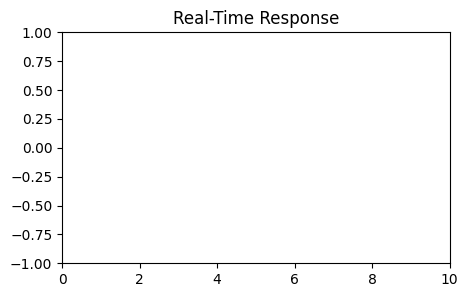

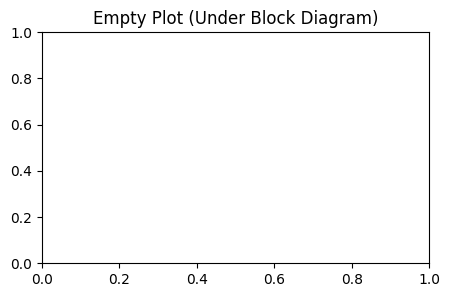

In [68]:
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
from ipycytoscape import CytoscapeWidget
import time

# Create network graph
cyto_graph = CytoscapeWidget()

nodes = [
    {"data": {"id": "P", "label": "CT Plant Model"}, "position": {"x": 500, "y": 100}},
    {"data": {"id": "ZOH", "label": "Zero-Order Hold"}, "position": {"x": 350, "y": 100}},
    {"data": {"id": "C", "label": "DT PID Controller"}, "position": {"x": 200, "y": 100}},
    {"data": {"id": "S", "label": "Sampler"}, "position": {"x": 50, "y": 100}},
    {"data": {"id": "F", "label": "Anti-Aliasing Filter"}, "position": {"x": -100, "y": 100}},
    {"data": {"id": "N", "label": "Noise Source"}, "position": {"x": -100, "y": 200}},

    # Routing nodes for feedback loop
    {"data": {"id": "R1", "label": ""}, "position": {"x": 650, "y": 100}},
    {"data": {"id": "R2", "label": ""}, "position": {"x": 650, "y": 0}},
    {"data": {"id": "R3", "label": ""}, "position": {"x": -250, "y": 0}},
    {"data": {"id": "R4", "label": ""}, "position": {"x": -250, "y": 100}},
]

edges = [
    {"data": {"source": "S", "target": "C"}},
    {"data": {"source": "C", "target": "ZOH"}},
    {"data": {"source": "ZOH", "target": "P"}},

    # Feedback path with right-angle bends
    {"data": {"source": "P", "target": "R1"}},
    {"data": {"source": "R1", "target": "R2"}},
    {"data": {"source": "R2", "target": "R3"}},
    {"data": {"source": "R3", "target": "R4"}},
    {"data": {"source": "R4", "target": "F"}},

    {"data": {"source": "F", "target": "S"}},
    {"data": {"source": "N", "target": "F"}},
]

cyto_graph.graph.add_graph_from_json({"nodes": nodes, "edges": edges})
cyto_graph.set_layout(name="preset")

# Styling
cyto_graph.set_style([
    {'selector': 'node', 'style': {
        'label': 'data(label)',
        'width': '100px',
        'height': '40px',
        'background-color': '#add8e6',
        'shape': 'rectangle',
        'text-valign': 'center',
        'font-size': '10px'
    }},
    {'selector': '[id = "N"]', 'style': {'background-color': '#ff6666'}},
    {'selector': '[id ^= "R"]', 'style': {'background-color': 'white', 'border-color': 'black', 'border-width': '1px'}}
])

# Real-time plot (displayed in layout)
fig, ax = plt.subplots(figsize=(5, 3))
x_data, y_data = [], []
line, = ax.plot([], [], '-o')
ax.set_xlim(0, 10)
ax.set_ylim(-1, 1)
ax.set_title("Real-Time Response")

plot_output = widgets.Output()
with plot_output:
    display(fig)  # Display inside the widget output only (not directly)

# **Empty Plot (only in the canvas)**
fig_empty, ax_empty = plt.subplots(figsize=(5, 3))
ax_empty.set_title("Empty Plot (Under Block Diagram)")

empty_plot_output = widgets.Output()
with empty_plot_output:
    display(fig_empty)  # Ensure it only appears inside the layout

def update_plot(change):
    global x_data, y_data
    x_data.append(time.time() % 10)
    y_data.append(np.sin(x_data[-1] * 2 * np.pi * noise_frequency.value / 100))
    if len(x_data) > 10:
        x_data.pop(0)
        y_data.pop(0)
    line.set_xdata(x_data)
    line.set_ydata(y_data)
    ax.relim()
    ax.autoscale_view()
    fig.canvas.draw_idle()

# UI Elements near respective nodes
noise_check = widgets.Checkbox(value=True, description='Enable Noise')
noise_intensity = widgets.FloatSlider(min=0, max=1, step=0.01, value=0.5, description='Intensity')
noise_frequency = widgets.FloatSlider(min=0, max=10, step=1, value=2, description='Frequency (Hz)')

filter_check = widgets.Checkbox(value=True, description='Enable Filter')
filter_cutoff = widgets.FloatSlider(min=1, max=10, step=1, value=5, description='Cutoff (Hz)')

sampling_frequency = widgets.FloatSlider(min=1, max=10, step=5, value=1000, description='Sampling (Hz)')

# Attach event listeners
for widget in [noise_check, noise_intensity, noise_frequency, filter_check, filter_cutoff, sampling_frequency]:
    widget.observe(update_plot, names='value')

# Improved Layout with Only One Empty Plot
layout_grid = widgets.GridspecLayout(3, 2, width='100%')
layout_grid[0, 0] = cyto_graph
layout_grid[0, 1] = widgets.VBox([widgets.Label("Noise"), noise_check, noise_intensity, noise_frequency])
layout_grid[1, 1] = widgets.VBox([widgets.Label("Filter"), filter_check, filter_cutoff])
layout_grid[2, 1] = widgets.VBox([widgets.Label("Sampler"), sampling_frequency])
layout_grid[1, 0] = plot_output  # Keep real-time plot inside the layout
layout_grid[2, 0] = empty_plot_output  # Empty plot under block diagram, only inside the layout

display(layout_grid)


FloatSlider(value=1.0, description='Time Constant (τ):', max=10.0, min=0.1)

FloatSlider(value=1.0, description='Gain (K):', max=10.0, min=0.1)

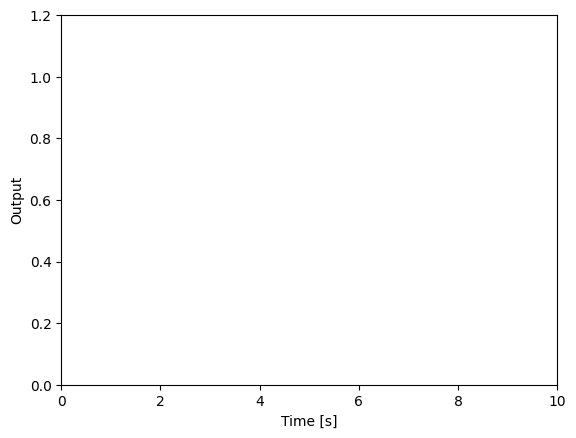

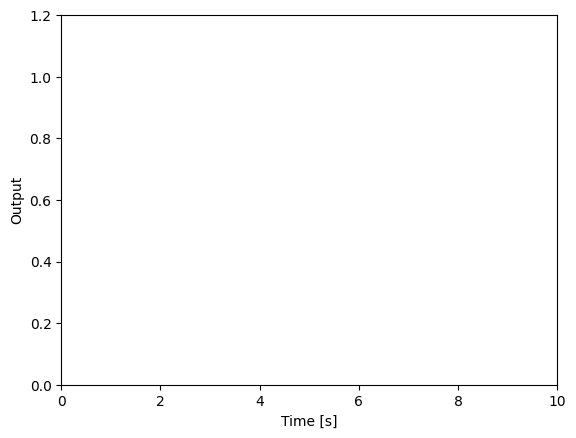

<Figure size 640x480 with 0 Axes>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import ipywidgets as widgets
from IPython.display import display

# Define the system parameters (for example, a simple first-order system)
def first_order_system(t, tau=1.0, K=1.0):
    return K * (1 - np.exp(-t / tau))

# Set up the figure and axis
fig, ax = plt.subplots()
xdata, ydata = [], []
line, = ax.plot([], [], lw=2)
ax.set_xlim(0, 10)
ax.set_ylim(0, 1.2)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Output')

# Initialize the plot's data
def init():
    line.set_data([], [])
    return line,

# Update function for the animation (representing system response)
def update(frame, tau, K):
    t = np.linspace(0, frame, frame+1)
    y = first_order_system(t, tau, K)
    line.set_data(t, y)
    return line,

# Create the animation with FuncAnimation
def animate(tau, K):
    ani = FuncAnimation(fig, update, frames=np.arange(1, 100), fargs=(tau, K), init_func=init, blit=True, interval=100)
    return ani

# Control parameters with sliders (interactive)
tau_slider = widgets.FloatSlider(value=1.0, min=0.1, max=10.0, step=0.1, description='Time Constant (τ):')
K_slider = widgets.FloatSlider(value=1.0, min=0.1, max=10.0, step=0.1, description='Gain (K):')

def update_params(change):
    # We stop any previous animation and start a new one with updated parameters
    ani.event_source.stop()  # Stop the existing animation if it's running
    plt.clf()  # Clear the current figure
    animate(tau_slider.value, K_slider.value)  # Start a new animation with updated parameters
    display(fig)

# Initialize the animation
ani = animate(tau_slider.value, K_slider.value)

# Link sliders to update function
tau_slider.observe(update_params, names='value')
K_slider.observe(update_params, names='value')

# Display the interactive controls and plot
display(tau_slider, K_slider, fig)
